# Find changepoints in raw positions

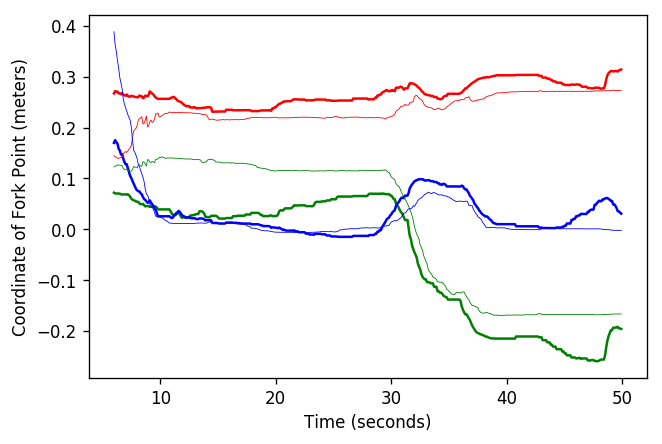

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
fig=plt.figure(dpi= 120, facecolor='w', edgecolor='k')
#### read in the txt file
import numpy as np
from statsmodels.nonparametric.smoothers_lowess import lowess
import matplotlib.pyplot as plt
raw_data = np.loadtxt('../data/spoon_poses_both.txt', delimiter=',')
#plt.plot(raw_data[:,(1,2,3,8,9,10)])
# Transform from second robot to frame of first robot
import transforms3d as t3d
q = [0, 0, 0, 1] # 180 degree rotation around z axis (w,x,y,z)
M = t3d.quaternions.quat2mat(q) # from this module
T = [[0.45, 0.06, 0]]
transform = np.concatenate((np.concatenate((M,np.transpose(T)),1),[[0,0,0,1]]))
# Plot the trajectories in the same coordinate frame
time = np.size(raw_data,0)
homogeneous_follower = np.transpose(np.concatenate((raw_data[:,1:4],np.ones((time,1))),1))
follower = np.transpose(np.dot(transform, homogeneous_follower))
follower.shape
same_frame_data = np.concatenate((raw_data[:,8:11],follower[:,0:3]),1)
from cycler import cycler
import matplotlib as mpl
mpl.rcParams['axes.prop_cycle'] = cycler(color='rgb')
relevant_indices = range(60,500)
plt.plot(raw_data[relevant_indices,0] - raw_data[0,0],raw_data[relevant_indices,8:11])
plt.plot(raw_data[relevant_indices,0] - raw_data[0,0],follower[relevant_indices,0:3],linewidth=0.5)
plt.xlabel("Time (seconds)")
plt.ylabel("Coordinate of Fork Point (meters)");

# Model both arms together

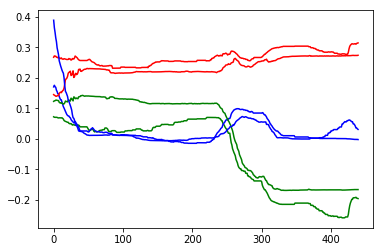

In [50]:
both_arms = np.concatenate((raw_data[relevant_indices,8:11],follower[relevant_indices,0:3]),1)
plt.plot(both_arms)

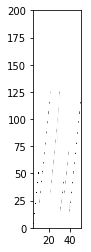

In [69]:
import sys
import numpy as np
sys.path.insert(0, "../scripts")
import changepoint_detector.gaussian_model as gm
import changepoint_detector.changepoint_detector as chd
num_variables=6
max_duration = len(relevant_indices) + 2
# set apriori parameters
apriori_n = 3
apriori_mean = np.zeros(num_variables)
apriori_ssd = np.ones(num_variables) * 2 / 100000

model_generator = gm.GaussianPredictor(num_variables, apriori_n, apriori_mean, apriori_n / 2, apriori_ssd / 2).Fit
reset_prob = 1/(300)
change_detector = chd.ChangepointDetector(both_arms, reset_prob, model_generator, max_duration)
result_probs = change_detector.ModelChangepoints()


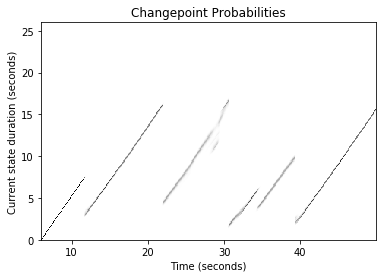

In [176]:
xcoords = raw_data[relevant_indices,0] - raw_data[0,0]
plt.imshow(np.transpose(1-result_probs[:,0:200]), cmap='gray', origin='lower',extent=[min(xcoords),max(xcoords),0,xcoords[200]], aspect = "auto")
plt.xticks(np.arange(10,50,10))
plt.title("Changepoint Probabilities")
plt.xlabel("Time (seconds)")
plt.ylabel("Current state duration (seconds)");

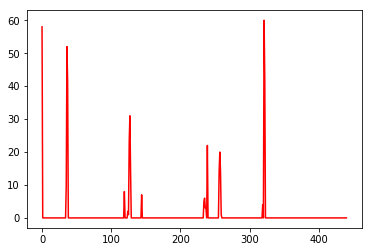

In [127]:
# early transition identification
maxtime = result_probs.shape[0]
min_trans_est = range(result_probs.shape[0]) - np.argmax(result_probs,1)
plt.plot([sum(min_trans_est == i) for i in range(maxtime)])
trans_starts = np.where(np.array([sum(min_trans_est == i) for i in range(maxtime)]) > 15)[0]
cleaned_trans_starts = []
for t in trans_starts:
    if t-1 not in cleaned_trans_starts:
        cleaned_trans_starts.append(t)

In [102]:
np.where(np.histogram(min_trans_est,bins=result_probs.shape[0])[0]>20)

(array([  0,  49,  50, 172, 173, 327, 439, 440]),)

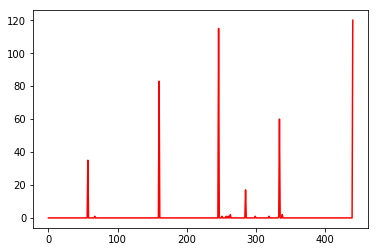

In [129]:
# late transition identification
max_trans_est = np.array([np.max(np.where(range(result_probs.shape[0]) - np.argmax(result_probs,1) <= i)[0]) for i in range(result_probs.shape[0])])
plt.plot([sum(max_trans_est == i) for i in range(maxtime)])
trans_ends = np.where(np.array([sum(max_trans_est == i) for i in range(maxtime)]) > 15)[0]
cleaned_trans_ends = []
for t in trans_ends:
    if t-1 not in cleaned_trans_ends:
        cleaned_trans_ends.append(t)

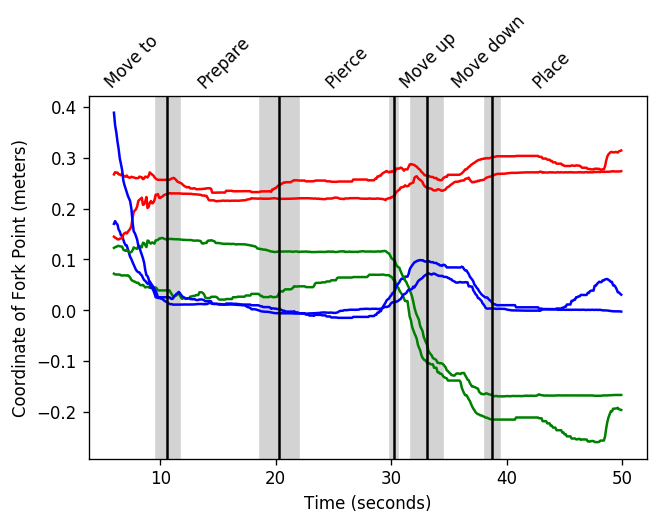

In [174]:

fig=plt.figure(dpi= 120, facecolor='w', edgecolor='k')
xcoords = raw_data[relevant_indices,0] - raw_data[0,0]
both_arms = np.concatenate((raw_data[relevant_indices,8:11],follower[relevant_indices,0:3]),1)
plt.plot(xcoords,both_arms)

for i in range(5):
    plt.axvspan(xmin=xcoords[cleaned_trans_starts[i+1]],xmax=xcoords[cleaned_trans_ends[i]],color="lightgrey")
    plt.axvline(x=xcoords[int(np.floor((cleaned_trans_starts[i+1]+cleaned_trans_ends[i])/2))],color="black")
    
plt.text(5 ,0.43,'Move to',{'va': 'bottom'}, rotation=45)
plt.text(13,0.43,'Prepare',{'va': 'bottom'}, rotation=45)
plt.text(24,0.43,'Pierce',{'va': 'bottom'}, rotation=45)
plt.text(30.5,0.43,'Move up',{'va': 'bottom'}, rotation=45)
plt.text(35,0.43,'Move down',{'va': 'bottom'}, rotation=45)
plt.text(42,0.43,'Place',{'va': 'bottom'}, rotation=45)
plt.xlabel("Time (seconds)")
plt.ylabel("Coordinate of Fork Point (meters)");

In [123]:
trans_starts

(array([  0,  36,  37, 126, 127, 239, 257, 321, 322]),)

# Model first arm

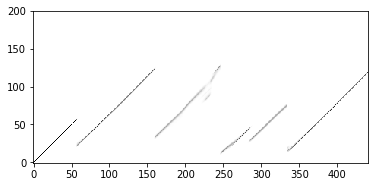

In [61]:
import sys
import numpy as np
sys.path.insert(0, "../scripts")
import changepoint_detector.gaussian_model as gm
import changepoint_detector.changepoint_detector as chd
num_variables=3
max_duration = len(relevant_indices) + 2
# set apriori parameters
apriori_n = 3
apriori_mean = np.zeros(num_variables)
apriori_ssd = np.ones(num_variables) * 2 / 100000

model_generator = gm.GaussianPredictor(num_variables, apriori_n, apriori_mean, apriori_n / 2, apriori_ssd / 2).Fit
reset_prob = 1/(300)
change_detector = chd.ChangepointDetector(raw_data[relevant_indices,8:11], reset_prob, model_generator, max_duration)
result_probs_first_arm = change_detector.ModelChangepoints()

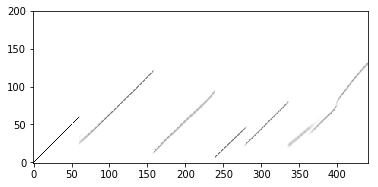

In [67]:

plt.imshow(np.transpose(1-result_probs_first_arm[:,0:200]), cmap='gray', origin='lower')

# Find changepoints in first differences

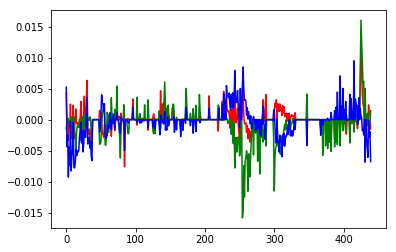

In [16]:
plt.plot(raw_data[np.array(relevant_indices) + 1,8:11] - raw_data[relevant_indices,8:11])

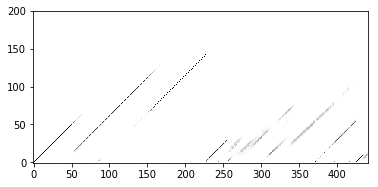

In [15]:
apriori_ssd = np.ones(num_variables) * 2 / 50000
model_generator = gm.GaussianPredictor(num_variables, apriori_n, apriori_mean, apriori_n / 2, apriori_ssd / 2).Fit
change_detector = chd.ChangepointDetector(raw_data[np.array(relevant_indices) + 1,8:11] - raw_data[relevant_indices,8:11], reset_prob, model_generator, max_duration)
result_probs = change_detector.ModelChangepoints()
plt.imshow(np.transpose(1-result_probs[:,0:200]), cmap='gray', origin='lower')

# Model second arm position

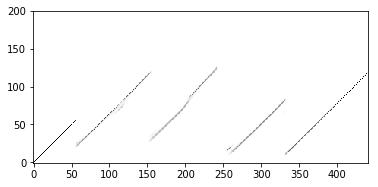

In [23]:
# set apriori parameters
apriori_n = 3
apriori_mean = np.zeros(num_variables)
apriori_ssd = np.ones(num_variables) * 2 / 100000

model_generator = gm.GaussianPredictor(num_variables, apriori_n, apriori_mean, apriori_n / 2, apriori_ssd / 2).Fit
reset_prob = 1/(300)
change_detector = chd.ChangepointDetector(follower[relevant_indices,0:3], reset_prob, model_generator, max_duration)
result_probs = change_detector.ModelChangepoints()
plt.imshow(np.transpose(1-result_probs[:,0:200]), cmap='gray', origin='lower')

# Model second for relative to first

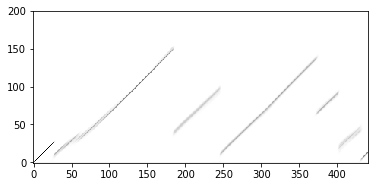

In [45]:
apriori_n = 3
apriori_mean = np.zeros(num_variables)
apriori_ssd = np.ones(num_variables) * 2 / 10

import changepoint_detector.multiple_model_changepoint_detector as mmchd
model_generator = gm.GaussianPredictor(num_variables, apriori_n, apriori_mean, apriori_n / 2, apriori_ssd / 2).Fit
model_generator_diff = gm.GaussianPredictor(num_variables, apriori_n, apriori_mean, apriori_n / 2, apriori_ssd/4 / 2).Fit
reset_prob = 1/(30)
change_detector = mmchd.MultipleModelChangepointDetector(
                                          (follower[relevant_indices,0:3]-raw_data[relevant_indices,8:11],
                                           follower[relevant_indices,0:3]), 
                                          (reset_prob,reset_prob*10), 
                                          (model_generator_diff,model_generator), 
                                          max_duration)
result_probs = change_detector.ModelChangepoints()
plt.imshow(np.transpose(1-result_probs[0][:,0:200]), cmap='gray', origin='lower')

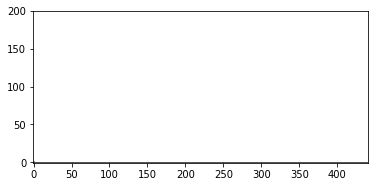

In [46]:
plt.imshow(np.transpose(1-result_probs[1][:,0:200]), cmap='gray', origin='lower')

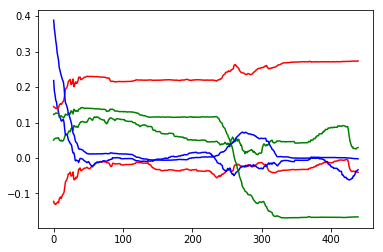

In [38]:
diff_data = follower[relevant_indices,0:3]-raw_data[relevant_indices,8:11]
pos_data = follower[relevant_indices,0:3]
plt.plot(diff_data)
plt.plot(pos_data)

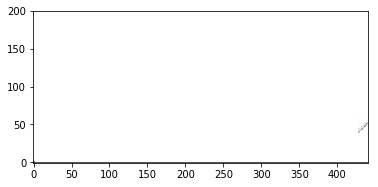

In [34]:
plt.imshow(np.transpose(1-result_probs[1][:,0:200]), cmap='gray', origin='lower')

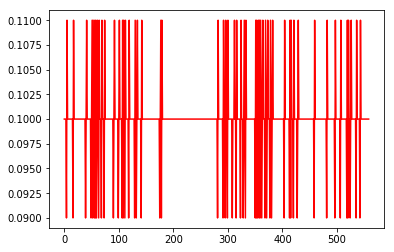

In [11]:
# you really don't have to worry about unequal timing spacing. Each data point is 100ms +/- 10ms apart
plt.plot(raw_data[1:,0]-raw_data[:-1,0])